## pipeline

In [1]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import segment_super_vox_3_channel, semantic_segment_crop_and_cat_3_channel_output, img_3d_erosion_or_expansion, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.run_pipeline import segment, assign_boudary_voxels_to_cells, dbscan_of_seg, semantic_segment_crop_and_cat
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_lite
from func.unet_3d_basic import UNet3D_basic
from func.ultis import save_obj, load_obj

### init model

In [2]:
# model=UNet3D_basic(in_channels = 1, out_channels = 3)
# load_path=''
# model=VoxResNet(input_channel=1, n_classes=3, output_func = "softmax")
# load_path=""


model=CellSegNet_basic_lite(input_channel=1, n_classes=3, output_func = "softmax")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

load_path='output/model_HMS_delete_fake_cells.pkl'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

model.eval()


#summary(model, (1, 64, 64, 64))

CellSegNet_basic_lite(
  (conv1): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bnorm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule1): ResModule(
    (batchnorm_module): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule2): ResModule(
    (batchnorm_module): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule3): R

### dataset info

In [3]:
HMS_data_dict = load_obj("dataset_info/HMS_dataset_info")
HMS_data_dict_test = HMS_data_dict["test"]

### seg one img

parameter setting

In [4]:
# we do not input the whole raw image to the model one time but input raw image crops
crop_cube_size=64
stride=32

# hyperparameter for TASCAN, min touching area of two super pixels if they belong to the same cell
min_touching_area=30

choose a test image and load it

In [5]:
print("Test cases: "+str(HMS_data_dict_test.keys()))
case = "135"
print("for test case "+str(case)+" : "+str(HMS_data_dict_test[case]))

# you may load the image using another path
raw_img=np.load(HMS_data_dict_test[case]["raw"]) # .astype(float)
print(HMS_data_dict_test[case]["raw"])
hand_seg=np.load(HMS_data_dict_test[case]["ins"]).astype(float)

Test cases: dict_keys(['135', '120', '65', '90'])
for test case 135 : {'raw': 'data/CellSeg_dataset/HMS_processed/raw/135.npy', 'background': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_background_3d_mask.npy', 'edge': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_edge_3d_mask.npy', 'edge_foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_edge_foreground_3d_mask.npy', 'centroid_foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_centroid_foreground_3d_mask.npy', 'edge_background': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_edge_background_3d_mask.npy', 'boundary': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_boundary_3d_mask.npy', 'foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_foreground_3d_mask.npy', 'ins': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_ins.npy'}
data/CellSeg_dataset/HMS_processed/raw/135.npy


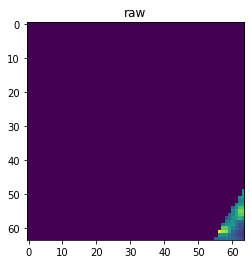

In [6]:
test_img_cropped = raw_img[0:64, 0:64, 0:64]
plt.figure()
plt.title("raw")
plt.imshow(test_img_cropped[:,50,:])

feed raw image crops to the model

In [7]:
start = time.time()

# feed the raw img to the model
print('Feed raw img to model')
raw_img_size=raw_img.shape
    
seg_background_comp = np.zeros(raw_img_size)
seg_boundary_comp = np.zeros(raw_img_size)

transposes = [[0,1,2]]#,[2,0,1],[0,2,1]]
reverse_transposes = [[0,1,2]]#,[1,2,0],[0,2,1]]

for idx, transpose in enumerate(transposes):
    print(str(idx+1)+": Transpose the image to be: "+str(transpose))
    # with torch.no_grad():
    seg_img=\
    semantic_segment_crop_and_cat_3_channel_output(raw_img.transpose(transpose), model, device, crop_cube_size=crop_cube_size, stride=stride)
    seg_img_background=seg_img['background']
    seg_img_boundary=seg_img['boundary']
    seg_img_foreground=seg_img['foreground']
    torch.cuda.empty_cache()
    
    # argmax
    print('argmax', end='\r')
    seg=[]
    seg.append(seg_img_background)
    seg.append(seg_img_boundary)
    seg.append(seg_img_foreground)
    seg=np.array(seg)
    seg_argmax=np.argmax(seg, axis=0)
    # probability map to 0 1 segment
    seg_background=np.zeros(seg_img_background.shape)
    seg_background[np.where(seg_argmax==0)]=1
    seg_foreground=np.zeros(seg_img_foreground.shape)
    seg_foreground[np.where(seg_argmax==2)]=1
    seg_boundary=np.zeros(seg_img_boundary.shape)
    seg_boundary[np.where(seg_argmax==1)]=1
        
    seg_background=seg_background.transpose(reverse_transposes[idx])
    seg_foreground=seg_foreground.transpose(reverse_transposes[idx])
    seg_boundary=seg_boundary.transpose(reverse_transposes[idx])
        
    seg_background_comp+=seg_background
    seg_boundary_comp+=seg_boundary
#print("Get model semantic seg by combination")
seg_background_comp = np.array(seg_background_comp>0, dtype=float)
seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=float)
seg_foreground_comp = np.array(1 - seg_background_comp - seg_boundary_comp>0, dtype=float)

end = time.time()

print("Time elapsed: ", end - start)

Feed raw img to model
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Time elapsed:  216.3645739555359


5

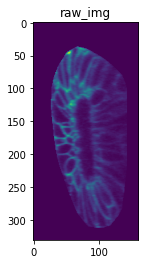

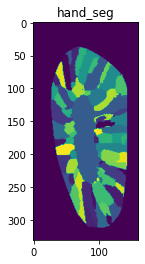

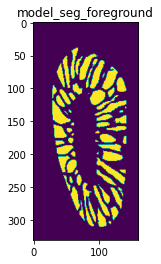

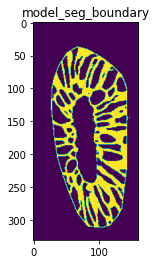

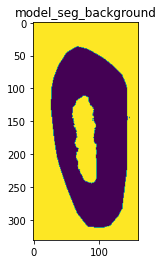

In [8]:
# show current result

N=100

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[N,:,:])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[N,:,:]))
plt.figure()
plt.title("model_seg_foreground")
plt.imshow(seg_foreground_comp[N,:,:])
plt.figure()
plt.title("model_seg_boundary")
plt.imshow(seg_boundary_comp[N,:,:])
plt.figure()
plt.title("model_seg_background")
plt.imshow(seg_background_comp[N,:,:])

TASCAN

generate super vox by watershed

In [9]:
how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

In [10]:
print("There are "+str(len(np.unique(seg_foreground_super_voxel_by_ws)))+" super voxels")

There are 1951 super voxels


super voxel clustearing

In [11]:
cluster_super_vox=Cluster_Super_Vox(min_touching_area=min_touching_area, min_touching_percentage=min_touching_percentage)
cluster_super_vox.fit(seg_foreground_super_voxel_by_ws)
seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img

crop_outlayer_area: 24current_crop_outlayer_area: 13current_crop_outlayer_area: 2current_crop_outlayer_area: 1current_crop_outlayer_area: 83current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 15current_crop_outlayer_area: 16current_crop_outlayer_area: 0current_crop_outlayer_area: 1current_crop_outlayer_area: 0current_crop_outlayer_area: 1current_crop_outlayer_area: 67current_crop_outlayer_area: 4current_crop_outlayer_area: 3current_crop_outlayer_area: 25current_crop_outlayer_area: 76current_crop_outlayer_area: 88current_crop_outlayer_area: 9current_crop_outlayer_area: 2current_crop_outlayer_area: 19current_crop_outlayer_area: 6current_crop_outlayer_area: 2current_crop_outlayer_area: 45current_crop_outlayer_area: 0current_crop_outlayer_area: 33current_crop_outlayer_area: 1current_crop_outlayer_area: 85current_crop_outlayer_area: 8current_crop_outlayer_area: 22current_

delete too small cells

In [12]:
min_cell_size_threshold=10
seg_foreground_single_cell_with_boundary_delete_too_small = delete_too_small_cluster(seg_foreground_single_cell_with_boundary, threshold=min_cell_size_threshold)

assign boudary voxels to their nearest cells

In [13]:
seg_final=assign_boudary_voxels_to_cells_with_watershed(seg_foreground_single_cell_with_boundary_delete_too_small, seg_boundary_comp, seg_background_comp, compactness=1)

see the final result

In [14]:
def colorful_seg(seg):
    unique_vals, val_counts = np.unique(seg, return_counts=True)
    
    background_val = unique_vals[np.argsort(val_counts)[::-1][0]]
    
    seg_RGB = []
    for i in range(seg.shape[0]):
        mask_gray = cv2.normalize(src=seg[i,:,:], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        seg_slice_RGB = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
        seg_RGB.append(seg_slice_RGB)
    seg_RGB = np.array(seg_RGB)
    
    for idx, unique_val in enumerate(unique_vals):
        print(str(idx/len(unique_vals)), end="\r")
        if unique_val == background_val:
            COLOR = np.array([0,0,0], dtype=int)
        else:
            COLOR = np.array(np.random.choice(np.arange(256), size=3, replace=False), dtype=int)
        
        locs = np.where(seg==unique_val)
        
        for i in range(3):
            seg_RGB[locs[0], locs[1], locs[2], i] = COLOR[i]
        
    return seg_RGB

In [15]:
seg_RGB = colorful_seg(seg_final)
hand_seg_RGB = colorful_seg(hand_seg)

465306122448979560.487755102040816350.51020408163265310.53265306122448970.55510204081632650.57755102040816330.60.62244897959183680.64489795918367340.66734693877551020.6897959183673470.71224489795918370.73469387755102040.75714285714285710.77959183673469390.80204081632653060.82448979591836740.84693877551020410.86938775510204080.89183673469387760.91224489795918360.93265306122448980.95306122448979590.97346938775510210.99591836734693870.00.0207373271889400930.0414746543778801850.062211981566820280.082949308755760370.103686635944700460.122119815668202760.142857142857142850.163594470046082960.184331797235023050.205069124423963130.225806451612903220.244239631336405530.264976958525345640.28571428571428570.30645161290322580.32718894009216590.3479262672811060.36866359447004610.389400921658986150.410138248847926270.43087557603686640.449308755760368660.47004608294930880.490783410138248830.5115207373271890.5322580645161290.55299539170506920.57373271889400920.59447004608294930.61520737327188930.63594

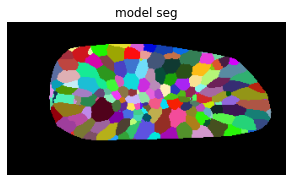

In [16]:
N=100
fig = plt.figure(figsize=(5,5))
plt.title("model seg")
plt.axis('off')
plt.imshow(seg_RGB[:,:,N,:])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

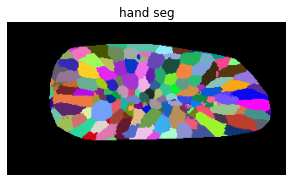

In [17]:
fig = plt.figure(figsize=(5,5))
plt.title("hand seg")
plt.axis('off')
plt.imshow(hand_seg_RGB[:,:,N,:])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

In [18]:
# print("There are "+str(len(np.unique(seg_final)))+" cells in model prediction")
# print("There are "+str(len(np.unique(hand_seg)))+" cells in hand seg")

calculate accuracy

In [19]:
ARI = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
ARE = adapted_rand_error(hand_seg.astype(int).flatten(), seg_final.astype(int).flatten())
VOI_val = VOI(seg_final.astype(int),hand_seg.astype(int))

In [20]:
print("ARI: "+str(ARI))
print("ARE: "+str(ARE))
print("VOI: "+str(VOI_val))

ARI: 0.973644745727811
ARE: (0.29505626537965857, 0.6668739154079556, 0.747623292044143)
VOI: (1.1643798217879262, 1.0203083411909382)


In [21]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

scale_factor = 0.5
org_shape = seg_final.shape
output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
print(str(org_shape)+" --> "+str(output_size))

(181, 331, 160) --> (90, 165, 80)


In [22]:
accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size), img_3d_interpolate(seg_final, output_size = output_size))
accuracy_record=accuracy.cal_accuracy_II()

iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

print('avg iou: '+str(np.mean(accuracy_record[:,1])))
print('avg dice: '+str(np.mean(accuracy_record[:,2])))

rogress: 12.76595744680851%progress: 14.095744680851062%progress: 14.893617021276595%progress: 15.691489361702127%progress: 16.48936170212766%progress: 17.5531914893617%progress: 18.617021276595743%progress: 20.212765957446805%progress: 21.01063829787234%progress: 21.808510638297875%progress: 23.138297872340424%progress: 24.73404255319149%progress: 26.063829787234045%progress: 27.127659574468083%progress: 28.191489361702125%progress: 29.521276595744684%progress: 30.851063829787233%progress: 32.71276595744681%progress: 34.308510638297875%progress: 35.90425531914894%progress: 37.5%progress: 38.56382978723404%progress: 39.62765957446808%progress: 40.95744680851064%progress: 42.02127659574468%progress: 43.08510638297872%progress: 44.41489361702128%progress: 45.744680851063826%progress: 47.07446808510639%progress: 48.138297872340424%progress: 49.734042553191486%progress: 51.06382978723404%progress: 52.12765957446809%progress: 53.98936170212766%progress: 55.58510638297872%progress: 56.648936

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/259725777.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/259725777.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:,2

### seg all imgs

In [23]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

def pipeline(raw_img, hand_seg, model, device,
             crop_cube_size, stride,
             how_close_are_the_super_vox_to_boundary=2,
             min_touching_area=30,
             min_touching_percentage=0.51,
             min_cell_size_threshold=1,
             transposes = [[0,1,2]], reverse_transposes = [[0,1,2]]):
    
    seg_final=segment_super_vox_3_channel(raw_img, model, device,
                                          crop_cube_size=crop_cube_size, stride=stride,
                                          how_close_are_the_super_vox_to_boundary=how_close_are_the_super_vox_to_boundary,
                                          min_touching_area=min_touching_area,
                                          min_touching_percentage=min_touching_percentage,
                                          min_cell_size_threshold=min_cell_size_threshold,
                                          transposes = transposes, reverse_transposes = reverse_transposes)
    
    ari = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
    voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))
    
    scale_factor = 0.5
    org_shape = seg_final.shape
    output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
    print(str(org_shape)+" --> "+str(output_size))
    
    accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size),
                                   img_3d_interpolate(seg_final, output_size = output_size))
    accuracy_record=accuracy.cal_accuracy_II()
    hand_seg_after_accuracy=accuracy.gt
    seg_final_after_accuracy=accuracy.pred
    
    return accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final

In [24]:
# mass process
seg_final_dict={}
accuracy_record_dict = {}
ari_dict = {}
voi_dict = {}
for test_file in HMS_data_dict_test.keys():
    print(test_file)
    raw_img=np.load(HMS_data_dict_test[test_file]["raw"])
    hand_seg=np.load(HMS_data_dict_test[test_file]["ins"])
    accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final=\
    pipeline(raw_img, hand_seg, model, device,
             crop_cube_size=64,
             stride=32)
    
    seg_final_dict[test_file] = seg_final
    accuracy_record_dict[test_file] = accuracy_record
    ari_dict[test_file] = ari
    voi_dict[test_file] = voi
    
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")

135
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Get model semantic seg by combination
crop_outlayer_area: 24current_crop_outlayer_area: 1current_crop_outlayer_area: 60current_crop_outlayer_area: 0current_crop_outlayer_area: 30current_crop_outlayer_area: 10current_crop_outlayer_area: 3current_crop_outlayer_area: 2current_crop_outlayer_area: 10current_crop_outlayer_area: 0current_crop_outlayer_area: 88current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 44current_crop_outlayer_area: 125current_crop_outlayer_area: 18current_crop_outlayer_area: 47current_crop_outlayer_area: 16current_crop_outlayer_area: 0current_crop_outlayer_area: 93current_crop_outlayer_area: 50current_crop_outlayer_area: 0current_crop_outlayer_area: 19current_crop_outlayer_area: 38current_crop_outlayer_area: 0current_crop_outlayer_area: 29current_crop_outlayer_area: 25current_crop_outlayer_area: 34current_crop_outlayer_a

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
rogress: 9.042553191489363%progress: 10.106382978723403%progress: 10.904255319148938%progress: 11.436170212765957%progress: 12.5%progress: 13.563829787234042%progress: 14.361702127659576%progress: 15.159574468085108%progress: 15.691489361702127%progress: 16.48936170212766%progress: 17.5531914893617%progress: 18.617021276595743%progress: 20.212765957446805%progress: 20.74468085106383%progress: 21.27659574468085%progress: 22.074468085106382%progress: 23.670212765957448%progress: 25.0%progress: 26.063829787234045%progress: 27.127659574468083%progress: 27.659574468085108%progress: 28.98936170212766%progress: 30.319148936170215%progress: 32.180851063829785%progress: 32.97872340425532%progress: 34.57446808510639%progress: 36.17021276595745%progress: 37.5%progress: 38.297872340425535%progress: 39.62765957446808%progress: 40.691489361702125%progress: 41.755319148936174%progress: 42.819148936170215%progress: 44.148936170212764%progress: 45.744680851063826%progr

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

cell count accuracy iou >0.7: 0.48936170212765956
cell count accuracy dice >0.7: 0.6702127659574468
cell count accuracy iou >0.5: 0.6941489361702128
cell count accuracy dice >0.5: 0.8058510638297872
avg iou: 0.5868948443911652
avg dice: 0.6946495438757492
ari: 0.9736479880526389
voi: (1.219066249405667, 0.9898737827037047)
----------
120
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Get model semantic seg by combination
]86]_crop_outlayer_area: 16current_crop_outlayer_area: 6current_crop_outlayer_area: 4current_crop_outlayer_area: 70current_crop_outlayer_area: 6current_crop_outlayer_area: 0current_crop_outlayer_area: 3current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 71current_crop_outlayer_area: 0current_crop_outlayer_area: 190current_crop_outlayer_area: 72current_crop_outlayer_area: 36current_crop_outlayer_area: 0current_crop_outlayer_area: 45current_crop

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
cell count accuracy iou >0.7: 0.6095505617977528876404496%progress: 25.842696629213485%progress: 26.685393258426966%progress: 27.52808988764045%progress: 28.08988764044944%progress: 28.651685393258425%progress: 29.49438202247191%progress: 30.337078651685395%progress: 31.179775280898873%progress: 32.02247191011236%progress: 33.146067415730336%progress: 33.98876404494382%progress: 34.831460674157306%progress: 35.95505617977528%progress: 36.51685393258427%progress: 37.640449438202246%progress: 38.48314606741573%progress: 39.04494382022472%progress: 40.168539325842694%progress: 41.57303370786517%progress: 42.97752808988764%progress: 44.38202247191011%progress: 45.78651685393258%progress: 46.91011235955056%progress: 48.59550561797753%progress: 50.0%progress: 51.68539325842697%progress: 53.37078651685393%progress: 54.7752808988764%progress: 56.17977528089888%progress: 57.58426966292135%progress: 58.70786516853933%progress: 59.8314606741573%progress: 61.23595

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

s of segment_3d_img: 99%Get model semantic seg by combination
]431]t_crop_outlayer_area: 11current_crop_outlayer_area: 0current_crop_outlayer_area: 1current_crop_outlayer_area: 59current_crop_outlayer_area: 51current_crop_outlayer_area: 9current_crop_outlayer_area: 6current_crop_outlayer_area: 24current_crop_outlayer_area: 34current_crop_outlayer_area: 36current_crop_outlayer_area: 12current_crop_outlayer_area: 0current_crop_outlayer_area: 5current_crop_outlayer_area: 99current_crop_outlayer_area: 8current_crop_outlayer_area: 0current_crop_outlayer_area: 84current_crop_outlayer_area: 26current_crop_outlayer_area: 1current_crop_outlayer_area: 49current_crop_outlayer_area: 0current_crop_outlayer_area: 26current_crop_outlayer_area: 15current_crop_outlayer_area: 9current_crop_outlayer_area: 21current_crop_outlayer_area: 0current_crop_outlayer_area: 17current_crop_outlayer_area: 0current_crop_outlayer_area: 43current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_ar

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
cell count accuracy iou >0.7: 0.595394736842105368421052%progress: 8.223684210526317%progress: 10.197368421052632%progress: 11.842105263157894%progress: 13.486842105263158%progress: 15.131578947368421%progress: 16.447368421052634%progress: 17.105263157894736%progress: 19.078947368421055%progress: 20.723684210526315%progress: 22.039473684210524%progress: 23.026315789473685%progress: 23.684210526315788%progress: 24.671052631578945%progress: 25.657894736842106%progress: 26.644736842105267%progress: 27.960526315789476%progress: 29.276315789473685%progress: 29.93421052631579%progress: 31.25%progress: 32.56578947368421%progress: 33.881578947368425%progress: 34.868421052631575%progress: 35.85526315789473%progress: 36.84210526315789%progress: 37.82894736842105%progress: 39.14473684210527%progress: 40.46052631578947%progress: 41.776315789473685%progress: 43.09210526315789%progress: 43.75%progress: 45.39473684210527%progress: 46.381578947368425%progress: 47.3684

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

s of segment_3d_img: 99%Get model semantic seg by combination
crop_outlayer_area: 0current_crop_outlayer_area: 1current_crop_outlayer_area: 0current_crop_outlayer_area: 84current_crop_outlayer_area: 57current_crop_outlayer_area: 4current_crop_outlayer_area: 97current_crop_outlayer_area: 27current_crop_outlayer_area: 0current_crop_outlayer_area: 29current_crop_outlayer_area: 38current_crop_outlayer_area: 0current_crop_outlayer_area: 26current_crop_outlayer_area: 2current_crop_outlayer_area: 12current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 14current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 2current_crop_outlayer_area: 56current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 4current_crop_outlayer_area: 1current_crop_outlayer_area: 23current_crop_outlayer_area: 140current_crop_outlayer_area: 37current_crop_outlayer_area: 30current_crop_outlayer_area: 13current_crop_outlayer_area: 0cu

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
cell count accuracy iou >0.7: 0.5238095238095238
cell count accuracy dice >0.7: 0.6386554621848739
cell count accuracy iou >0.5: 0.6666666666666666
cell count accuracy dice >0.5: 0.7871148459383753
avg iou: 0.5756088763361937
avg dice: 0.6753178384280255
ari: 0.9992223402453654
voi: (1.0529112617655234, 1.0090642370685687)
----------


/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

In [25]:
for item in seg_final_dict.keys():
    print(item)
    accuracy_record = accuracy_record_dict[item]
    ari = ari_dict[item]
    voi = voi_dict[item]
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")

135
cell count accuracy iou >0.7: 0.48936170212765956
cell count accuracy dice >0.7: 0.6702127659574468
cell count accuracy iou >0.5: 0.6941489361702128
cell count accuracy dice >0.5: 0.8058510638297872
avg iou: 0.5868948443911652
avg dice: 0.6946495438757492
ari: 0.9736479880526389
voi: (1.219066249405667, 0.9898737827037047)
----------
120
cell count accuracy iou >0.7: 0.6095505617977528
cell count accuracy dice >0.7: 0.7303370786516854
cell count accuracy iou >0.5: 0.7415730337078652
cell count accuracy dice >0.5: 0.8539325842696629
avg iou: 0.6427446935257843
avg dice: 0.7390070864721463
ari: 0.983667383549732
voi: (1.0290148350281947, 0.8645936763072571)
----------
65
cell count accuracy iou >0.7: 0.5953947368421053
cell count accuracy dice >0.7: 0.7105263157894737
cell count accuracy iou >0.5: 0.7335526315789473
cell count accuracy dice >0.5: 0.8552631578947368
avg iou: 0.6456745970369268
avg dice: 0.747994557905354
ari: 0.9989481872661446
voi: (0.9390963948219857, 0.949463185797

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/1383077988.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_4329/1383077988.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[: